<a target="_blank" href="https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Grokking_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Setup
(No need to read)

In [ ]:
TRAIN_MODEL = True

In [ ]:
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install transformer_lens
    %pip install circuitsvis
    %pip install einops
    %pip install torchtyping
    %pip install numpy
    %pip install SymPy
    %pip install torch_geometric


Running as a Colab notebook


In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [ ]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
from torch_geometric.data import Data

from transformers import AutoModel, AutoTokenizer
import networkx as nx
import numpy as np

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

Plotting helper functions:

In [ ]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [ ]:
# where we save the model
PTH_LOCATION = "/workspace/_scratch/grokking_demo.pth"

In [ ]:
#Help by ChatGPT
def generate_random_graph(min_vertices=15, max_vertices=15):
    n_vertices = np.random.randint(min_vertices, max_vertices + 1)
    min_edges = max(n_vertices - 1, 1)
    max_edges = max(n_vertices * (n_vertices - 1) // 2, min_edges + 1)
    n_edges = np.random.randint(min_edges, max_edges)
    graph = nx.gnm_random_graph(n_vertices, n_edges)
    return graph


def serialize_graph(graph):
    adjacency_matrix = nx.to_numpy_array(graph)
    flat_adjacency = adjacency_matrix.flatten()
    node_features = np.array(list(graph.nodes()))
    serialized_sequence = np.concatenate([flat_adjacency, node_features])
    return serialized_sequence

def create_dataset(num_graphs):
    dataset = []
    for _ in range(num_graphs):
        graph = generate_random_graph()
        serialized_graph = serialize_graph(graph)
        v1, v2 = np.random.choice(graph.nodes(), 2, replace=False)
        path_exists = nx.has_path(graph, v1, v2)
        dataset.append((serialized_graph, v1, v2, path_exists))
    return dataset

# Generate the dataset
p = 1000
graph_dataset = create_dataset(p)

# Print the first dataset entry
print(graph_dataset[0])


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

# Model Training

## Config

In [ ]:
lr = 1e-4
wd = 1e-4
betas = (0.9, 0.98)
frac_train = 0.7

num_epochs =  25000
checkpoint_every = 100

momentum = 0.9

total_size = len(graph_dataset)
train_size = int(total_size * frac_train)
test_size = total_size - train_size

train_dataset = graph_dataset[:train_size]
test_dataset = graph_dataset[train_size:]


In [ ]:
train_data = [(data[0], data[1], data[2]) for data in train_dataset]
test_data = [(data[0], data[1], data[2]) for data in test_dataset]
train_labels = [label[3] for label in train_dataset]
test_labels = [label[3] for label in test_dataset]

train_data_tensors = [torch.tensor(np.concatenate(([v1, v2], serialized_graph)), dtype=torch.float) for serialized_graph, v1, v2 in train_data]
test_data_tensors = [torch.tensor(np.concatenate(([v1, v2], serialized_graph)), dtype=torch.float) for serialized_graph, v1, v2 in test_data]

train_labels = torch.tensor(train_labels, dtype=torch.float)
test_labels = torch.tensor(test_labels, dtype=torch.float)

train_data = torch.stack(train_data_tensors)
test_data = torch.stack(test_data_tensors)

print(f"Train Data Shape: {train_data.shape}, Train Labels Shape: {train_labels.shape}")
print(f"Test Data Shape: {test_data.shape}, Test Labels Shape: {test_labels.shape}")


Train Data Shape: torch.Size([700, 242]), Train Labels Shape: torch.Size([700])
Test Data Shape: torch.Size([300, 242]), Test Labels Shape: torch.Size([300])


## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|b|=|

In [ ]:
import torch.optim as optim

cfg = HookedTransformerConfig(
   n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 256,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=12,
    d_vocab_out=1,
    n_ctx=1,
    init_weights=True,
    device="cuda",
    seed = 999,
)

model = HookedTransformer(cfg)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=wd)

RuntimeError: ignored

Convert this to a train + test set - 30% in the training set

In [ ]:
import tqdm
# from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming you have defined train_data and test_data as Dataset objects
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
# test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_fn)

train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []

loss_function = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()

    # Forward pass on the entire training dataset
    train_logits = model(train_data.long())
    # print("train_logits shape:", train_logits.shape)
    train_logits = train_logits[:, -1]
    train_loss = loss_function(train_logits.squeeze(), train_labels.float().to(device))

    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # Evaluation on the entire test dataset
    model.eval()
    with torch.no_grad():
        test_logits = model(test_data.long())
        test_logits = test_logits[:, -1]
        test_loss = loss_function(test_logits.squeeze(), test_labels.float().to(device))
        test_losses.append(test_loss.item())
    # scheduler.step(test_loss)


    # Checkpointing logic
    if (epoch + 1) % checkpoint_every == 0:
        checkpoint_epochs.append(epoch)
        model_checkpoints.append(copy.deepcopy(model.state_dict()))
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss.item()} Test Loss: {test_loss.item()}")

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: ignored

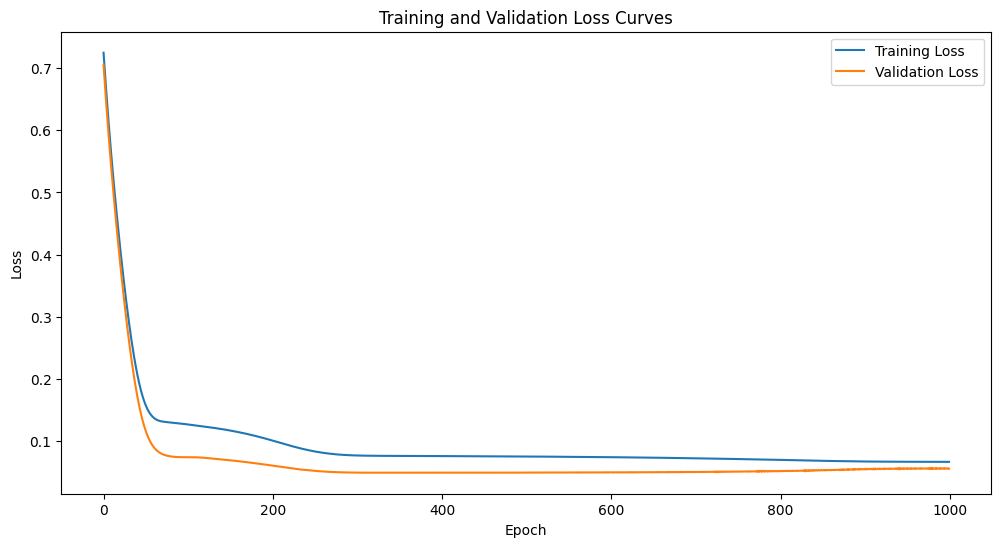

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
